In [51]:
class_names = dict((
(0, "Water"),
(1, "Snow/Ice"),
(2, "Open Space Developed"),
(3, "Low Intensity Developed"),
(4, "Medium Intensity Developed"),
(5, "High Intensity Developed"),
(6, "Barren Land"),
(7, "Deciduous Forest"),
(8, "Evergreen Forest"),
(9, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(10, "Scrub/Shrub"),
(11, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(12, "Pasture/Hay"),
(13, "Cultivated Land"),
(14, "Woody Wetland"),
(15, "Emergent Herbaceous Wetlands"),
))


In [52]:
import rasterio
import numpy as np
import random
import math
import itertools
import os
import sys
import resnet as rs
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu
importlib.reload(cu)

<module 'classifier_utilities' from '/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py'>

In [53]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [54]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))

In [55]:
more_pixels = cu.gen_balanced_pixel_locations(landsat_datasets[2:3], 40000, label_dataset)

100%|██████████| 1/1 [00:42<00:00, 42.97s/it]


In [56]:
pixels = cu.gen_balanced_pixel_locations(landsat_datasets[2:3], 70000, label_dataset)

100%|██████████| 1/1 [00:47<00:00, 47.15s/it]


In [57]:
buckets = cu.pixel_balance(pixels, landsat_datasets[2:3], label_dataset)

In [58]:
for i in range(len(class_names)):
    print(class_names[i])
    print(buckets[i])

Water
4375.0
Snow/Ice
0.0
Open Space Developed
4375.0
Low Intensity Developed
0.0
Medium Intensity Developed
4375.0
High Intensity Developed
0.0
Barren Land
4375.0
Deciduous Forest
4375.0
Evergreen Forest
4375.0
Mixed Forest
4375.0
Scrub/Shrub
4375.0
Grassland / Herbaceous
4375.0
Pasture/Hay
4375.0
Cultivated Land
4375.0
Woody Wetland
4375.0
Emergent Herbaceous Wetlands
4375.0


In [59]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.7, 0.8)

In [60]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

39812
13650
6143


In [61]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands,img_rows, img_cols)
print(input_shape)


(10, 64, 64)


In [62]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model

In [63]:
def make_model(in_shape):
    input_tensor = Input(shape = in_shape)
    conv_1 = SeparableConv2D(64, kernel_size=(2,2), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)
    pool = MaxPooling2D() (dropout_1)
    flatten = Flatten() (pool)
    dense = Dense(128, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (dense)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [64]:
model = rs.ResnetBuilder.build_resnet_50(input_shape,num_classes)
#model = make_model(input_shape)

In [65]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets[2:3], sentinel_datasets[2:3], dem_datasets[2:3], label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets[2:3], sentinel_datasets[2:3], dem_datasets[2:3], label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
1592/1592 [==============================] - 469s 295ms/step - loss: 3.5958 - acc: 0.3461 - val_loss: 2.3458 - val_acc: 0.3768
Epoch 2/200
1592/1592 [==============================] - 451s 283ms/step - loss: 2.0844 - acc: 0.4138 - val_loss: 2.1437 - val_acc: 0.3637
Epoch 3/200
1592/1592 [==============================] - 451s 283ms/step - loss: 1.8683 - acc: 0.4525 - val_loss: 2.0102 - val_acc: 0.4203
Epoch 4/200
1592/1592 [==============================] - 455s 286ms/step - loss: 1.7234 - acc: 0.4921 - val_loss: 2.0196 - val_acc: 0.4159
Epoch 5/200
1592/1592 [==============================] - 454s 285ms/step - loss: 1.6146 - acc: 0.5289 - val_loss: 2.3874 - val_acc: 0.3603
Epoch 6/200
1592/1592 [==============================] - 452s 284ms/step - loss: 1.5152 - acc: 0.5682 - val_loss: 2.2532 - val_acc: 0.4130
Epoch 7/200
1592/1592 [==============================] - 454s 285ms/step - loss: 1.4103 - acc: 0.6083 - val_loss: 2.7887 - val_acc: 0.3721
Epoch 8/200
1592/1592 [====

In [43]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets[2:3], sentinel_datasets[2:3], dem_datasets[2:3], 
        label_dataset, tile_side, tile_side, more_pixels, batch_size), 
                        steps=len(more_pixels) // batch_size,
                         verbose=1)

eval_generator = cu.tile_generator(landsat_datasets[2:3], sentinel_datasets[2:3], dem_datasets[2:3], 
                                label_dataset, tile_side, tile_side, more_pixels, batch_size=1)

1300/1300 [==============================] - 155s 119ms/step


In [44]:
buckets = cu.pixel_balance(more_pixels, landsat_datasets[2:3], label_dataset)

In [45]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

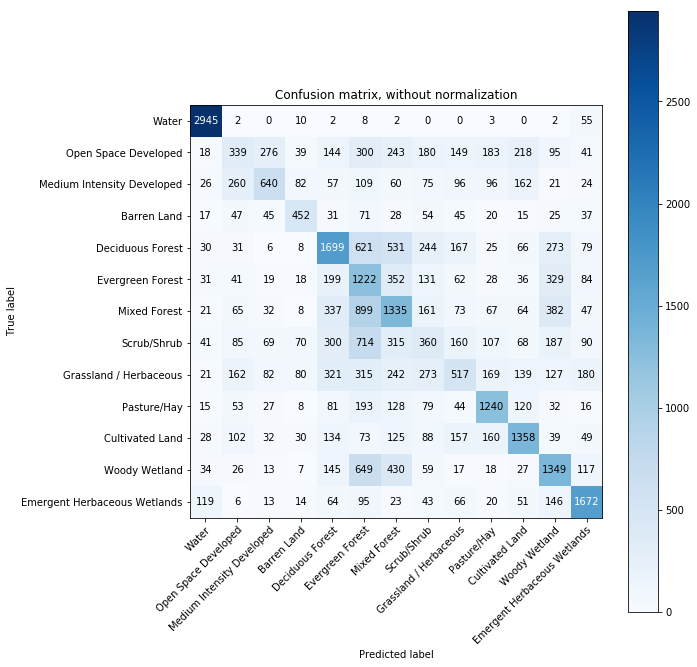

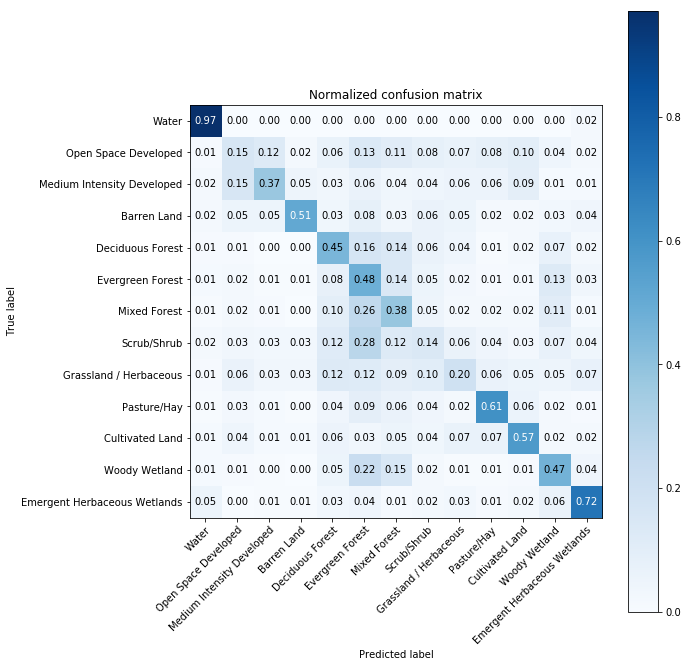

In [46]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [47]:
print(buckets)

[2500.    0. 2500.    0. 2500.    0. 2500. 2500. 2500. 2500. 2500. 2500.
 2500. 2500. 2500. 2500.]


In [49]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.46547692307692307
